# Latent Factor-Based Recommender System


In this notebook I will use basic Latent Factor Models, to predict movie ratings

## A) Choosing, cleaning and tidying up Data

For this activity I will be using a **small version** of the MovieLens dataset.
Note that according to the page:

>This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.
Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.
The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.
This is a development dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available benchmark datasets if that is your intent.


Further details can be found [here](https://grouplens.org/datasets/movielens/).

In [1]:
import pandas as pd
from collections import defaultdict
import scipy
import scipy.optimize
import numpy
import random
import csv

From this site, we will use both ```ratings``` and ```movies``` datasets (both in csv), and join them for a full picture. For simplicity, we will use the Pandas library.

In [2]:
ratings=pd.read_csv('ratings.csv')

I will check the number of total reviews:

In [3]:
len(ratings)

100836

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings.set_index(['userId','movieId']).head()

rating  timestamp
userId movieId                   
1      1           4.0  964982703
       3           4.0  964981247
       6           4.0  964982224
       47          5.0  964983815
       50          5.0  964982931

¿Could there be any movie reviewed more than once by a particular user? I will find out:

In [6]:
len(ratings.set_index(['userId','movieId']).index.unique())-len(ratings.index.unique())

0

Which means there are no repetition in ```userId``` / ```movieId```combinations

In [7]:
movies=pd.read_csv('movies.csv')

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
len(movies.set_index(['movieId','title']).index.unique())-movies.index.nunique()

0

It seems that there is no redundancy in in ```movieId``` / ```title```combinations. Now we can merge both dataframes, in a new one called ```df```.

I am dropping unnecessary features (each film will be identified by its title).

In [10]:
df = ratings.merge(movies)
df.drop(columns=['movieId','timestamp','genres'], inplace = True)
df.head()

,userId,rating,title
0,1,4.0,Toy Story (1995)
1,5,4.0,Toy Story (1995)
2,7,4.5,Toy Story (1995)
3,15,2.5,Toy Story (1995)
4,17,4.5,Toy Story (1995)


I would like to know how are ratings distributed, so i'll plot an histogram, and obtain some statistics.

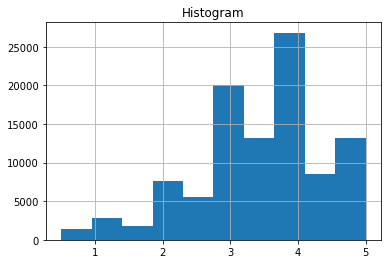

In [11]:
df.rating.hist().set_title('Histogram');

It seems like there is some kind of "bimodality" in ratings

In [12]:
df.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

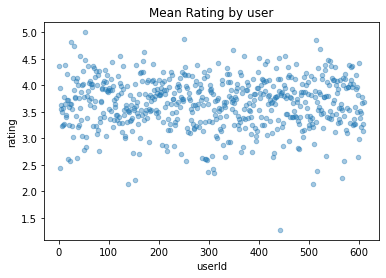

In [13]:
df_plot=df.groupby(['userId'])['rating'].mean().reset_index()
df_plot.plot(kind='scatter',x = 'userId', y = 'rating', alpha=0.4,title='Mean Rating by user');

In [14]:
df.rating.value_counts(sort=True)

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

By observation, I can conclude two peculiar issues in this dataset:
- Ratings are not necessarily integer numbers
- Ratings under 2 are very rare: ratings are slightly biased towards good ratings

¿Is there any missing or zero value?

In [15]:
df.isna().sum()

userId    0
rating    0
title     0
dtype: int64

There are no missing values, so now we write a new file with this merged file (comma separated).

In [16]:
df.to_csv('movieReviews.csv',index=False)

From this file, I will obtain:
- a ```dataset``` list
- a ```ReviewsPerUser``` dictionary
- a ```ReviewsPermovie``` dictionary

In [17]:
dataset = []
with open('movieReviews.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        row['rating'] = float(row['rating'])
        dataset.append(row)

In [18]:
#We will need these dictionaries down below, Lets create them now
reviewsPerUser = defaultdict(list)
reviewsPerMovie = defaultdict(list)

for d in dataset:
    user,movie = d['userId'], d['title']
    reviewsPerUser[user].append(d)
    reviewsPerMovie[movie].append(d)

Some examples:

In [19]:
dataset[4219]

OrderedDict([('userId', '314'), ('rating', 3.0), ('title', 'Batman (1989)')])

¿Which movies has the ```userId``` 325 reviewed?

In [20]:
reviewsPerUser['325'][:10]

[OrderedDict([('userId', '325'), ('rating', 4.0), ('title', 'Heat (1995)')]),
 OrderedDict([('userId', '325'), ('rating', 3.0), ('title', 'Clerks (1994)')]),
 OrderedDict([('userId', '325'),
              ('rating', 5.0),
              ('title', 'Ed Wood (1994)')]),
 OrderedDict([('userId', '325'),
              ('rating', 5.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '325'),
              ('rating', 2.0),
              ('title', 'Forrest Gump (1994)')]),
 OrderedDict([('userId', '325'),
              ('rating', 5.0),
              ('title', 'Silence of the Lambs, The (1991)')]),
 OrderedDict([('userId', '325'),
              ('rating', 1.0),
              ('title', 'Twister (1996)')]),
 OrderedDict([('userId', '325'),
              ('rating', 4.0),
              ('title', 'Wizard of Oz, The (1939)')]),
 OrderedDict([('userId', '325'),
              ('rating', 3.0),
              ('title', 'Bedknobs and Broomsticks (1971)')]),
 OrderedDict([('userId',

¿What ratings has the *Pulp Fiction* obtained?

In [21]:
reviewsPerMovie['Pulp Fiction (1994)'][:10]

[OrderedDict([('userId', '1'),
              ('rating', 3.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '4'),
              ('rating', 1.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '5'),
              ('rating', 5.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '6'),
              ('rating', 2.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '8'),
              ('rating', 4.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '10'),
              ('rating', 1.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '14'),
              ('rating', 3.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '15'),
              ('rating', 4.0),
              ('title', 'Pulp Fiction (1994)')]),
 OrderedDict([('userId', '16'),
              ('rating', 3.0),
              ('title', 'Pulp Fiction 

## B) Modelling a First Latent Factor-Based Recomender


As a first step, I'll have to  build some aditional data structures to store the variables and parameters.

After that I'll use gradient descent to implement a latent-factor model (technically, ML).

In [22]:
#Length for reviews, different users and different movies
N = len(dataset)
nUsers = len(reviewsPerUser)
nMovies = len(reviewsPerMovie)

#I will need a list for the keys
users = list(reviewsPerUser.keys())
movies = list(reviewsPerMovie.keys())

#This is our first estimation, just a mean rating
alpha = sum([d['rating'] for d in dataset]) / len(dataset)

#Create another two defaultdict's, this time being float types because they are prediction based
userBiases = defaultdict(float)
movieBiases = defaultdict(float)

#Mean squared error will give me a sense of how wrong am I. This metric should be minimized.
def MSE(predictions, labels):
    diffs = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(diffs) / len(diffs)

A first prediction function will use: 
- A global quantity (alpha)
- A user offset (beta_user) 
- A movie offset (beta_movie)

In [23]:
def prediction(user, movie):
    return alpha + userBiases[user] + movieBiases[movie]

Note that gradient descent, which I'll use to obatin optimal parameters, require some previous operations. Thus, we'll need to "unpack" some vectors / matrices.

In [24]:
def unpack(theta):
    global alpha
    global userBiases
    global movieBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    movieBiases = dict(zip(movies, theta[1+nUsers:]))

The "cost" function to be minimized, will allow me to get optimal values for MSE.

In [25]:
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userId'], d['title']) for d in dataset]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases: #I don't want the biases to be very high!
        cost += lamb*userBiases[u]**2
    for i in movieBiases:#I don't want the biases to be very high!
        cost += lamb*movieBiases[i]**2
    return cost

This derivative function is based on the slides for the course (check slide 112 in the pdf provided as sumplementary material)

In [26]:
def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dmovieBiases = defaultdict(float)
    for d in dataset:
        u,i = d['userId'], d['title']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dmovieBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in movieBiases:
        dmovieBiases[i] += 2*lamb*movieBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dmovieBiases[i] for i in movies]
    return numpy.array(dtheta)

An obvious baseline is:

In [27]:
alwaysPredictMean = [alpha for d in dataset]
labels = [d['rating'] for d in dataset]

MSE(alwaysPredictMean, labels)

1.086856435732857

Now, we can use gradient descent, as implemented by scipy (details in [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html)
This version of gradient descent uses:

- [X] A cost function
- [x] Initial parameter values, obtained as indicated
- [x] A specific derivative function
- [x] Real Labels and a regularization factor

Note that we will optimize, obtaining iteratively:

In [28]:
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nMovies),
                             derivative, args = (labels, 0.001))

MSE = 1.086856435732857
MSE = 1.0247105479208047
MSE = 1.7799544604195812
MSE = 1.009523267085557
MSE = 0.9691478769518045
MSE = 0.9620957086004421
MSE = 0.937158342421175
MSE = 0.8781000472643767
MSE = 0.8554233681360223
MSE = 0.828193413052151
MSE = 0.8210706785544539
MSE = 0.8228478419681241
MSE = 0.8225103201974705
MSE = 0.8202223530860037
MSE = 0.8190044156283736
MSE = 0.8180993605477793
MSE = 0.8178628257659988
MSE = 0.8176503974216297
MSE = 0.8178123086923819
MSE = 0.8177188819142455
MSE = 0.817719326570152
MSE = 0.8177261631261439
MSE = 0.8176775976618196
MSE = 0.817655607836492
MSE = 0.8175985452666502
MSE = 0.8176276306437396
MSE = 0.8176312578215252
MSE = 0.8176331039583897
MSE = 0.8176326133157941
MSE = 0.817631123730643
MSE = 0.8176355527014733
MSE = 0.8176320084701069
MSE = 0.8176325412590711
MSE = 0.8176332369810259
MSE = 0.8176337072336108


(array([ 3.55072556e+00,  5.20438731e-01, -5.81680315e-03, ...,
        -6.40744844e-03, -1.50720319e-03, -1.50720319e-03]),
 0.8804652904133209,
 {'grad': array([-5.90920565e-06, -1.44000334e-06, -8.58999573e-08, ...,
          2.27426585e-08,  3.33243402e-09,  3.33243402e-09]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 35,
  'nit': 29,
  'warnflag': 0})

Note that I have a smaller MSE than before (0.8176 vs 1.086856435732857).

## C) Obtaining a definitive Latent Factor Model

For each user and movie we could have an ideally low dimensional descriptor of dimension K. For simplicity, we will use 2 (This could be easily interpretable using geometry).

In [29]:
userBiases = defaultdict(float)
movieBiases = defaultdict(float)
userGamma = {}
movieGamma = {}

K = 2

In [30]:
for u in reviewsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
    
for i in reviewsPerMovie:
    movieGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

The rest of the previous functions are almost the same that in the previous case

In [31]:
def unpack(theta):
    global alpha
    global userBiases
    global movieBiases
    global userGamma
    global movieGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    movieBiases = dict(zip(movies, theta[index:index+nMovies]))
    index += nMovies
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in movies:
        movieGamma[i] = theta[index:index+K]
        index += K

Similarly, our cost and derivative functions serve the same role as before, though their implementations are somewhat more complicated.

In [32]:
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])


def prediction(user, movie):
    return alpha + userBiases[user] + movieBiases[movie] + inner(userGamma[user], movieGamma[movie])


def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userId'], d['title']) for d in dataset]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in movies:
        cost += lamb*movieBiases[i]**2
        for k in range(K):
            cost += lamb*movieGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dmovieBiases = defaultdict(float)
    dUserGamma = {}
    dmovieGamma = {}
    for u in reviewsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in reviewsPerMovie:
        dmovieGamma[i] = [0.0 for k in range(K)]
    for d in dataset:
        u,i = d['userId'], d['title']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dmovieBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*movieGamma[i][k]*diff
            dmovieGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in movieBiases:
        dmovieBiases[i] += 2*lamb*movieBiases[i]
        for k in range(K):
            dmovieGamma[i][k] += 2*lamb*movieGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dmovieBiases[i] for i in movies]
    for u in users:
        dtheta += dUserGamma[u]
    for i in movies:
        dtheta += dmovieGamma[i]
    return numpy.array(dtheta)

Again we optimize using our gradient descent library, and compare to a simple baseline.

In [33]:
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nMovies) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nMovies))],
                             derivative, args = (labels, 0.001), maxfun = 50, maxiter = 100)

MSE = 1.0892854048851497
MSE = 1.6118944371896669
MSE = 1.0832221235135295
MSE = 1.0790145277919552
MSE = 1.0629883542048089
MSE = 0.929687817934958
MSE = 0.8976615151524262
MSE = 0.8456043753881812
MSE = 0.8294393125711914
MSE = 0.8237824803392985
MSE = 0.8225554060748077
MSE = 0.8195333443522673
MSE = 0.817850747101853
MSE = 0.8163188149964926
MSE = 0.8164101407848874
MSE = 0.8167444216244337
MSE = 0.8205155699589458
MSE = 0.8167743073133593
MSE = 0.816999248801452
MSE = 0.8170727369584909
MSE = 0.8171945739986715
MSE = 0.8174105139160824
MSE = 0.817631110171848
MSE = 0.8174818727723141
MSE = 0.8175163953753771
MSE = 0.8175409570750906
MSE = 0.8175754203121197
MSE = 0.8176227865127428
MSE = 0.8176218349390068
MSE = 0.8176191493689359
MSE = 0.8176186885745942
MSE = 0.8176207912235087


(array([ 3.55071230e+00,  5.20357975e-01, -5.81694014e-03, ...,
        -6.46640190e-06,  6.13549178e-06,  1.35448002e-06]),
 0.8804653542505197,
 {'grad': array([-5.43218356e-06, -2.02396499e-06, -9.42379108e-08, ...,
         -1.19398170e-08,  1.06224492e-08,  3.70194643e-09]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 32,
  'nit': 27,
  'warnflag': 0})

And note that our last MSE is slightly smaller than in the previous version. We set different parameters for ```maxfun``` and ```maxiter```, knowing that time / performance is not an issue.